Importing necessary libraries and setting up constants

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve


IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

Loading the dataset and partitioning it into training, validation, and test sets

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

def partition_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1, buffer_size=100):
    dataset = dataset.shuffle(buffer_size)
    n = len(dataset)
    train_n = int(train_size * n)
    val_n = int(val_size * n)
    train_dataset = dataset.take(train_n)
    val_dataset = dataset.skip(train_n).take(val_n)
    test_dataset = dataset.skip(train_n + val_n)
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = partition_dataset(dataset)

Found 14529 files belonging to 10 classes.


Preprocessing the datasets for performance

In [7]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Defining the model architecture and compiling it

In [8]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Training the model and evaluating it on the test dataset

In [9]:
EPOCHS = 25

history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size =BATCH_SIZE,
    verbose=1,
    validation_data = val_dataset
)


scores = model.evaluate(test_dataset)

Epoch 1/25


364/364 [==============================] - 2873s 5s/step - loss: 1.6283 - accuracy: 0.4318 - val_loss: 1.3540 - val_accuracy: 0.5354
Epoch 2/25
364/364 [==============================] - 1436s 4s/step - loss: 0.9903 - accuracy: 0.6539 - val_loss: 0.8592 - val_accuracy: 0.7007
Epoch 3/25
364/364 [==============================] - 1245s 3s/step - loss: 0.7142 - accuracy: 0.7474 - val_loss: 0.8896 - val_accuracy: 0.7181
Epoch 4/25
364/364 [==============================] - 1147s 3s/step - loss: 0.5828 - accuracy: 0.7916 - val_loss: 0.6277 - val_accuracy: 0.7840
Epoch 5/25
364/364 [==============================] - 1168s 3s/step - loss: 0.5061 - accuracy: 0.8201 - val_loss: 0.6564 - val_accuracy: 0.7785
Epoch 6/25
364/364 [==============================] - 1155s 3s/step - loss: 0.4462 - accuracy: 0.8416 - val_loss: 0.6504 - val_accuracy: 0.7944
Epoch 7/25
364/364 [==============================] - 1157s 3s/step - loss: 0.3952 - accuracy: 0.8590 - val_loss: 0.4891 - val_accurac

Saving the trained model

In [13]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


 Plotting training and validation loss

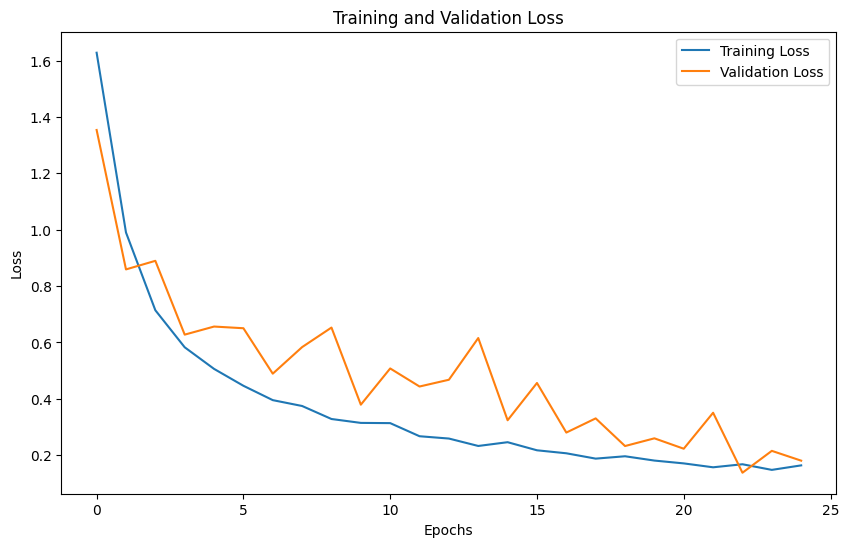

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plotting training and validation accuracy

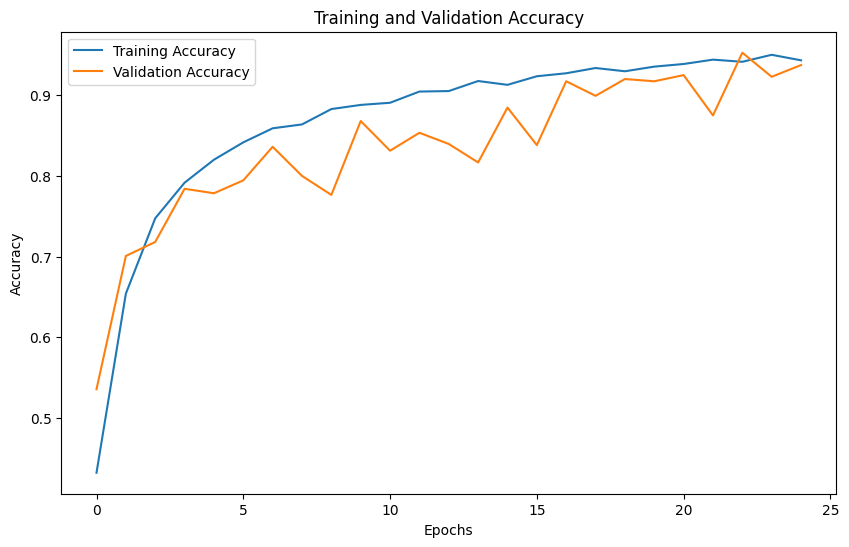

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


 Plotting confusion matrix

46/46 [==============================] - 28s 463ms/step


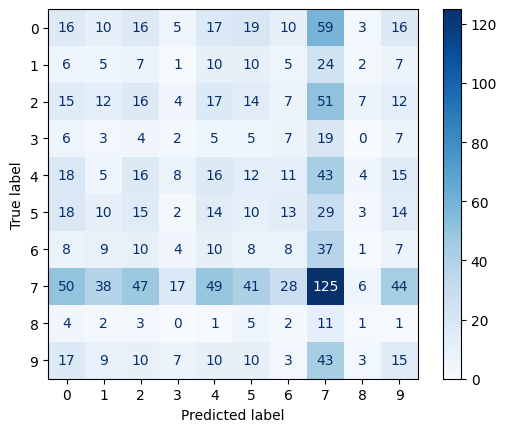

In [16]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=-1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(n_classes)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Precision

46/46 [==============================] - 85s 2s/step
Precision: 0.1565227319324936


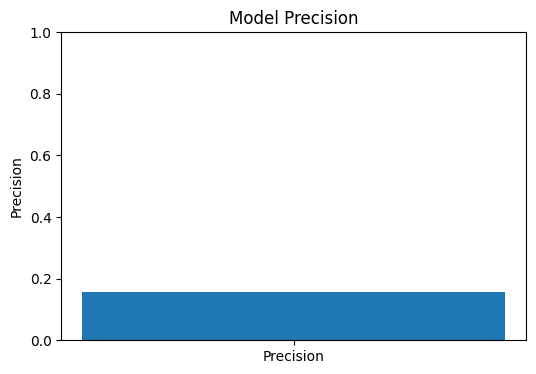

In [17]:
from sklearn.metrics import precision_score

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=-1)
precision = precision_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')

# Plot Precision (dummy plot as precision is a single value)
plt.figure(figsize=(6, 4))
plt.bar(['Precision'], [precision])
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.title('Model Precision')
plt.show()


Recall

Recall: 0.1554476058292852


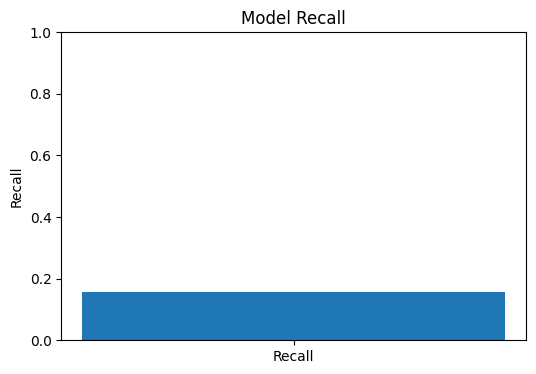

In [18]:
from sklearn.metrics import recall_score

recall = recall_score(y_true, y_pred, average='weighted')

print(f'Recall: {recall}')

# Plot Recall (dummy plot as recall is a single value)
plt.figure(figsize=(6, 4))
plt.bar(['Recall'], [recall])
plt.ylim(0, 1)
plt.ylabel('Recall')
plt.title('Model Recall')
plt.show()


F1 score

F1 Score: 0.15583109872928272


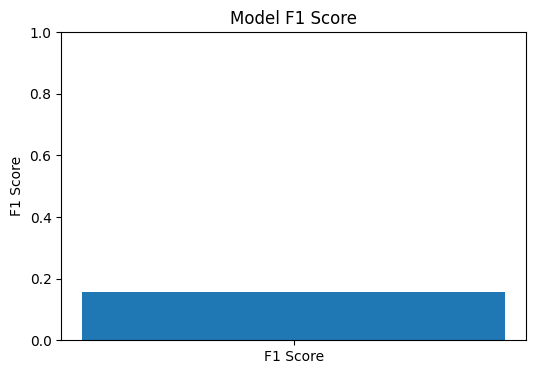

In [19]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average='weighted')

print(f'F1 Score: {f1}')

# Plot F1 Score (dummy plot as F1 score is a single value)
plt.figure(figsize=(6, 4))
plt.bar(['F1 Score'], [f1])
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.title('Model F1 Score')
plt.show()
